<a href="https://colab.research.google.com/github/semkud/nnmethods/blob/main/nnmethods2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchmetrics
!pip install ipdb
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics import F1
from torchmetrics.functional import f1, recall
import ipdb

     |████████████████████████████████| 329 kB 4.7 MB/s 
     |████████████████████████████████| 791 kB 4.2 MB/s 
     |████████████████████████████████| 374 kB 25.0 MB/s 
  Created wheel for ipdb: filename=ipdb-0.13.9-py3-none-any.whl size=11648 sha256=e53f559620a99d723560452b96d9636cec54b1d69ba57fb7162496da8721e946
  Stored in directory: /root/.cache/pip/wheels/65/cd/cc/aaf92acae337a28fdd2aa4d632196a59745c8c39f76eaeed01
Successfully built ipdb
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires p

Загружаем данные, делим на обучающую и валидационную выборки:

In [2]:
pos_tweets = pd.read_csv('positive.csv', encoding='utf-8', sep=';', header=None,  names=[0,1,2,'text','tone',5,6,7,8,9,10,11])
neg_tweets = pd.read_csv('negative.csv', encoding='utf-8', sep=';', header=None, names=[0,1,2,'text','tone',5,6,7,8,9,10,11] )
neg_tweets['tone'] = 0
all_tweets_data = pos_tweets.append(neg_tweets)
#print(len(all_tweets_data))
tweets_data = shuffle(all_tweets_data[['text','tone']])[:100000]
train_sentences, val_sentences = train_test_split(tweets_data, test_size=0.1)

In [3]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [4]:
vocab = Counter()

for text in tweets_data['text']:
    vocab.update(preprocess(text))
print('всего уникальных токенов:', len(vocab))


filtered_vocab = set()

for word in vocab:
    if vocab[word] > 2:
        filtered_vocab.add(word)
print('уникальных токенов, вcтретившихся больше 2 раз:', len(filtered_vocab))
#создаем словарь с индексами word2id, для спецсимвола паддинга дефолтный индекс - 0
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
#обратный словарь для того, чтобы раскодировать последовательность
id2word = {i:word for word, i in word2id.items()}


всего уникальных токенов: 202718
уникальных токенов, вcтретившихся больше 2 раз: 32511


Обучаем эмбеддинговую модель на текстах наших твиттов, устанавливаем размер эмбеддинга - 100

In [5]:
import gensim
texts = all_tweets_data.text.apply(preprocess).tolist()
w2v = gensim.models.Word2Vec(texts, size=100, window=5, min_count=1)

weights = np.zeros((len(word2id), 100))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = w2v.wv[word]    
    except KeyError:
      count += 1
      # oov словам сопоставляем случайный вектор
      weights[i] = np.random.normal(0,0.1,100)

In [6]:
weights.shape

(32512, 100)

In [7]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

## Задача 1

Класс Датасет для первой задачи нам подойдет с той пары, на которой мы рассматривали перептрон

In [8]:
class TweetsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['tone'].values
        self.device = DEVICE

    def __len__(self): #это обязательный метод, он должен уметь считать длину датасета
        return self.length

    def __getitem__(self, index): #еще один обязательный метод. По индексу возвращает элемент выборки
        tokens = self.preprocess(self.dataset[index]) # токенизируем
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return ids, y
    
    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      #мы хотим применять BCELoss, он будет брать на вход predicted размера batch_size x 1 (так как для каждого семпла модель будет отдавать одно число), target размера batch_size x 1
      y = torch.Tensor(y).to(self.device) # tuple ([1], [0], [1])  -> Tensor [[1.], [0.], [1.]] 
      return padded_ids, y

In [9]:
train_dataset = TweetsDataset(train_sentences, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [10]:
val_dataset = TweetsDataset(val_sentences, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

Пишем класс сетки.

1.Первое это эмбеддинги - подгружаем заранее обученные, в параметре freeze ставим False, соответственно эмбеддинги тоже будут дообучаться.
2.В сверточном слое у нас три фильтра с разными окнами: биграммы, биграммы со страйдом 2, триграмммы. У всех in_channels соответствует размеру эмбеддинга, out_channels - одинаковые, чтобы можно было конкатенировать по глубине.
3.Еще один сверточный слой - 3 входных канала (это конкатеннация предыдущих трех фильтров), 50 выходных.
4.Пуллинг везде - макс пуллинг овер тайм
5.Наконец последний линейный слой на входе у него 50, соответствует выходу с последнего сверточного, на выходе 1
6.Функция активации - сигмоида




In [64]:
class MLP(nn.Module):
    
    def __init__(self, vocab_size):
        
        super().__init__()          
        # указываем в атрибутах класса, какие слои и активации нам понадобятся
        self.embedding = nn.Embedding(vocab_size, 100)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=False) #@@@
        self.bigrams1 = nn.Conv1d(in_channels=100, out_channels=80, kernel_size=2, stride=1)
        self.bigrams2 = nn.Conv1d(in_channels=100, out_channels=80, kernel_size=2, stride=2)
        self.trigrams = nn.Conv1d(in_channels=100, out_channels=80, kernel_size=3, stride=1)
        self.cnn2 = nn.Conv1d(in_channels=3, out_channels=50, kernel_size=3, stride=1) #new


        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=50, out_features=1)
        self.dropout = nn.Dropout(p=0.1)
        self.out = nn.Sigmoid()
        
        
    def forward(self, text): #необходимый метод,  в нем указываем, как именно связываются слои/активации между собой
        # batch_size x seq_len
        #ipdb.set_trace()
        embedded = self.embedding(text)   # переводим последовательность индексов в последовательность эмбеддингов
        # batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams1 = self.dropout(self.pooling(self.relu(self.bigrams1(embedded))))
        #batch_size x filter_count21 x seq_len*
        feature_map_bigrams2 = self.dropout(self.pooling(self.relu(self.bigrams2(embedded))))
        #batch_size x filter_count22 x seq_len* 
        feature_map_trigrams = self.dropout(self.pooling(self.relu(self.trigrams(embedded))))
        #batch_size x filter_count3 x seq_len*

        pooling21 = feature_map_bigrams1.max(2)[0] 
        # batch_size x filter_count21
        pooling22 = feature_map_bigrams2.max(2)[0] 
        # batch_size x filter_count22
        pooling3 = feature_map_trigrams.max(2)[0]
        # batch_size x filter_count3

        concat = torch.stack((pooling21,pooling22,pooling3))
        # 3 x batch_size x 80
        concat = concat.transpose(0,1)
        # batch_size x 3 x 80

        feature_map_cnn2 = self.dropout(self.pooling(self.relu(self.cnn2(concat))))
        poolinglast = feature_map_cnn2.max(2)[0]

        logits = self.hidden(poolinglast)
        logits = self.out(logits)
        return logits

In [65]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(texts)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке
  
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

In [66]:
model = MLP(len(word2id))
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss() # Binary Cross Entropy

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []


for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.7658290714025497
Train loss: 0.7268395297455065
Train loss: 0.7123079967498779
Train loss: 0.7033443566578538
Train loss: 0.6963426378511247

Evaluating on train...
Val loss: 0.7037113197147846, Val f1: 0.5911188125610352
Val loss: 0.6828516270175125, Val f1: 0.571102499961853
Val loss: 0.6762748754024506, Val f1: 0.565504789352417
Val loss: 0.6724078085885119, Val f1: 0.5647856593132019
Val loss: 0.6701749868336178, Val f1: 0.5631181001663208

Evaluating on test...
Val loss: 1.3279680013656616, Val f1: 1.0777702331542969
Val loss: 0.8848335941632589, Val f1: 0.7196509838104248
Val loss: 0.7957148790359497, Val f1: 0.6581218838691711
Val loss: 0.7579631209373474, Val f1: 0.626775860786438
Val loss: 0.7369367943869697, Val f1: 0.6070888638496399

starting Epoch 1
Training...
Train loss: 0.6998934969305992
Train loss: 0.6750970446702206
Train loss: 0.6649915993213653
Train loss: 0.6587339452843168
Train loss: 0.6539941508145559

Evaluating on t

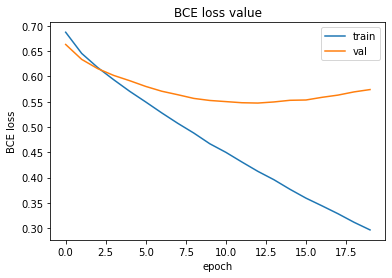

In [67]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

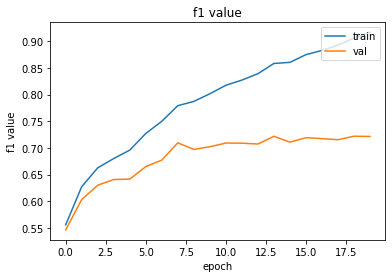

In [68]:
import matplotlib.pyplot as plt
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Как мы видим, модель обучается, и более того, довольно быстро переобучается, потому что функция потерь на обучении падает намного быстрее чем на тесте.

Попробуем немножко усовершенствовать модель. Увеличим лернинг рейт до 0.001, изменим dropout на 0.5, уменьшим число нейронов на линейном слое до 20

In [73]:
class MLP(nn.Module):
    
    def __init__(self, vocab_size):
        
        super().__init__()          
        # указываем в атрибутах класса, какие слои и активации нам понадобятся
        self.embedding = nn.Embedding(vocab_size, 100)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=False) #@@@
        self.bigrams1 = nn.Conv1d(in_channels=100, out_channels=80, kernel_size=2, stride=1)
        self.bigrams2 = nn.Conv1d(in_channels=100, out_channels=80, kernel_size=2, stride=2)
        self.trigrams = nn.Conv1d(in_channels=100, out_channels=80, kernel_size=3, stride=1)
        self.cnn2 = nn.Conv1d(in_channels=3, out_channels=20, kernel_size=3, stride=1) #new


        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=20, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()
        
        
    def forward(self, text): #необходимый метод,  в нем указываем, как именно связываются слои/активации между собой
        # batch_size x seq_len
        #ipdb.set_trace()
        embedded = self.embedding(text)   # переводим последовательность индексов в последовательность эмбеддингов
        # batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams1 = self.dropout(self.pooling(self.relu(self.bigrams1(embedded))))
        #batch_size x filter_count21 x seq_len*
        feature_map_bigrams2 = self.dropout(self.pooling(self.relu(self.bigrams2(embedded))))
        #batch_size x filter_count22 x seq_len* 
        feature_map_trigrams = self.dropout(self.pooling(self.relu(self.trigrams(embedded))))
        #batch_size x filter_count3 x seq_len*

        pooling21 = feature_map_bigrams1.max(2)[0] 
        # batch_size x filter_count21
        pooling22 = feature_map_bigrams2.max(2)[0] 
        # batch_size x filter_count22
        pooling3 = feature_map_trigrams.max(2)[0]
        # batch_size x filter_count3

        concat = torch.stack((pooling21,pooling22,pooling3))
        # 3 x batch_size x 80
        concat = concat.transpose(0,1)
        # batch_size x 3 x 80

        feature_map_cnn2 = self.dropout(self.pooling(self.relu(self.cnn2(concat))))
        poolinglast = feature_map_cnn2.max(2)[0]

        logits = self.hidden(poolinglast)
        logits = self.out(logits)
        return logits

In [74]:
model = MLP(len(word2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss() # Binary Cross Entropy

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []


for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.7578085474669933
Train loss: 0.724496765570207
Train loss: 0.71253999710083
Train loss: 0.705091159735153
Train loss: 0.6989562887521017

Evaluating on train...
Val loss: 0.7130956277251244, Val f1: 0.36950939893722534
Val loss: 0.6911896340774767, Val f1: 0.35730603337287903
Val loss: 0.6843758583068847, Val f1: 0.35134172439575195
Val loss: 0.6807116074348564, Val f1: 0.3496338725090027
Val loss: 0.6788044316428048, Val f1: 0.3471020460128784

Evaluating on test...
Val loss: 1.3452885746955872, Val f1: 0.6145856380462646
Val loss: 0.8948387702306112, Val f1: 0.43282896280288696
Val loss: 0.8052633762359619, Val f1: 0.39302632212638855
Val loss: 0.7672274964196342, Val f1: 0.37232863903045654
Val loss: 0.7459951705402799, Val f1: 0.3620135188102722

starting Epoch 1
Training...
Train loss: 0.7093257866799831
Train loss: 0.6861619479728468
Train loss: 0.6768670046329498
Train loss: 0.6722302490205907
Train loss: 0.6682226232119969

Evaluating

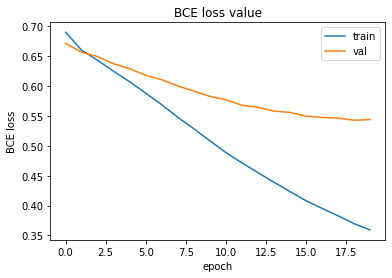

In [75]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

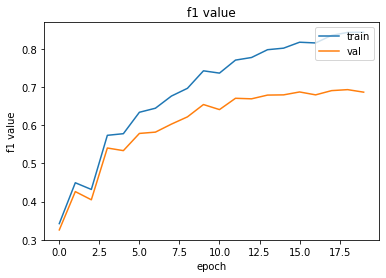

In [76]:
import matplotlib.pyplot as plt
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Не сказать, что стало явственно лучше и мы побороли переобучение, но если приглядеться, можно заметить, что bce_loss на 20 эпохах  на валидационной выборке всегда падает, уже нет такого, что оно снова начинает расти, и график заезжает ниже 0.55, а в первом варианте нашей сетки он всегда был выше.

## Задача 2

In [84]:
vocab2 = Counter()
for symbol in tweets_data['text']:
    vocab2.update(list(symbol))
print('всего уникальных символов:', len(vocab2))

filtered_vocab2 = set()

for symbol in vocab2:
    if vocab2[symbol] > 200:
        filtered_vocab2.add(symbol)
print('уникальных символов, втретившихся больше 5 раз:', len(filtered_vocab2))

всего уникальных символов: 341
уникальных символов, втретившихся больше 5 раз: 163


In [98]:
symb2id = {'PAD':0}

for symbol in filtered_vocab2:
    symb2id[symbol] = len(symb2id)
id2symb = {i:symbol for symbol, i in symb2id.items()}


In [100]:
a = ['as', 'as', 'ds']
''.join(a)

'asasds'

Для задачи 2 мы немного усовершенствуем датасет, чтобы получить две матрицы для разных входов

In [96]:
class TweetsDataset2(Dataset):

    def __init__(self, dataset, word2id, symb2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.symb2id = symb2id
        self.length = dataset.shape[0]
        self.target = dataset['tone'].values
        self.device = DEVICE

    def __len__(self): #это обязательный метод, он должен уметь считать длину датасета
        return self.length

    def __getitem__(self, index): #еще один обязательный метод. По индексу возвращает элемент выборки
        tokens = self.preprocess(self.dataset[index]) # токенизируем
        ids_word = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        tokensstring = ''.join(tokens)
        ids_symb = torch.LongTensor([self.symb2id[token] for token in tokensstring if token in self.symb2id])
        y = [self.target[index]]
        return ids_word, ids_symb, y
    
    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      ids_word, ids_symb, y = list(zip(*batch))
      padded_ids_word = pad_sequence(ids_word, batch_first=True).to(self.device)
      padded_ids_symb = pad_sequence(ids_symb, batch_first=True).to(self.device)
      #мы хотим применять BCELoss, он будет брать на вход predicted размера batch_size x 1 (так как для каждого семпла модель будет отдавать одно число), target размера batch_size x 1
      y = torch.Tensor(y).to(self.device) # tuple ([1], [0], [1])  -> Tensor [[1.], [0.], [1.]] 
      return padded_ids_word, padded_ids_symb, y

In [101]:
train_dataset = TweetsDataset2(train_sentences, word2id, symb2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [102]:
val_dataset = TweetsDataset2(val_sentences, word2id, symb2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [112]:
class CNN2(nn.Module):
    
    def __init__(self, vocab_size_words, vocab_size_symbs):
        super().__init__()

        self.embeddingwords = nn.Embedding(vocab_size_words, 100)
        self.embeddingwords.from_pretrained(torch.tensor(weights), freeze=True)
        self.emb2h = nn.Linear(100, 10)
        
        self.embeddingsymbs = nn.Embedding(vocab_size_symbs, 10)
        self.bigrams = nn.Conv1d(in_channels=10, out_channels=60, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=10, out_channels=30, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=100, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()


        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, text_words, text_symbs):
        #cначала слова
        embeddedwords = self.embeddingwords(text_words)
        mean_emb = torch.mean(embeddedwords, dim=1)
        X1 = self.dropout(self.relu(self.emb2h(mean_emb)))
        #теперь символы
        embeddedsymbs = self.embeddingsymbs(text_symbs)
        embeddedsymbs = embeddedsymbs.transpose(1,2)
        feature_map_bigrams = self.dropout(self.pooling(self.relu(self.bigrams(embeddedsymbs))))
        feature_map_trigrams = self.dropout(self.pooling(self.relu(self.trigrams(embeddedsymbs))))
        pooling1 = feature_map_bigrams.max(2)[0] 
        pooling2 = feature_map_trigrams.max(2)[0]
        concat = torch.cat((pooling1, pooling2, X1), 1)
        # batch _size x (filter_count2 + filter_count3)
        logits = self.hidden(concat) 
        logits = self.out(logits)      
        return logits
      

In [105]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (text_words, text_symbs, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(text_words, text_symbs)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (text_words, text_symbs, ys) in enumerate(iterator):   
            preds = model(text_words, text_symbs)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

In [113]:
model = CNN2(len(word2id),len(symb2id))
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(50):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  self.padding, self.dilation, self.groups)


Train loss: 0.7501299418509007
Train loss: 0.7206947803497314
Train loss: 0.7080442380905151
Train loss: 0.6997053133907603
Train loss: 0.6930946970269793

Evaluating on train...
Val loss: 0.7147233709692955, Val f1: 0.7158839702606201
Val loss: 0.6935645432183237, Val f1: 0.6937904357910156
Val loss: 0.68652046084404, Val f1: 0.6859506368637085
Val loss: 0.6828919942699262, Val f1: 0.6823459267616272
Val loss: 0.6805408469268254, Val f1: 0.6809853315353394

Evaluating on test...
Val loss: 1.3382514715194702, Val f1: 1.3725643157958984
Val loss: 0.8990925749142965, Val f1: 0.8891474008560181
Val loss: 0.8096268773078918, Val f1: 0.7992087602615356
Val loss: 0.7703493748392377, Val f1: 0.7652981877326965
Val loss: 0.7485297057363722, Val f1: 0.7456901669502258

starting Epoch 1
Training...
Train loss: 0.7043457254767418
Train loss: 0.6801320260221307
Train loss: 0.6718469691276551
Train loss: 0.6659466001524854
Train loss: 0.6615996410449346

Evaluating on train...
Val loss: 0.694161511

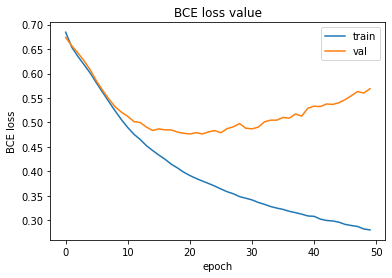

In [114]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

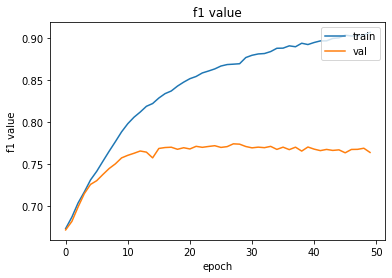

In [115]:
import matplotlib.pyplot as plt
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Наша модель определенно чему-то обучилась! Ф1 скор остановился на уровне 0.75, что выше чем для предыдущей модели, функция потерь в какой-то момент была ниже 0.50 на валидационной выборке..

Вывод - эта модель лучше предыдущей. Улучшений для этой модели придумывать не буду, но если улучшение для предыдущей было недостаточно убедительно, то сама вторая модель является улучшением для первой

Попробуем посмотреть, что наша модель предсказывает хорошо, а что не очень:

In [136]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (text_words, text_symbs, ys) in enumerate(iterator):   
            preds = model(text_words, text_symbs)  # делаем предсказания на тесте 
            for pred, gold, text in zip(preds, ys, text_words):
              text = ' '.join([id2word[int(id)] for id in text if id !=0])
              if round(pred.item()) > gold:
                fp.append(text)
              elif round(pred.item()) < gold:
                fn.append(text)
              elif round(pred.item()) == gold == 1:
                tp.append(text)
              elif round(pred.item()) == gold == 0:
                tn.append(text)
    return fp, fn, tp, tn

In [137]:
fp, fn, tp, tn = predict(model, val_iterator)

In [138]:
print('что правильно предсказываем:', tp[:10])

что правильно предсказываем: ['seeeptember везет а у меня вся музычка вк с а ты чего себя так на диету d', 'пользуюсь версией этого замечательного плеера от 08.11.09 приятное дополнение в windows7 наведя на значок плеера в та', 'у всех завтра 4 урока а у меня с физры ухожу d', 'для того что бы в на ногах держаться', 'доброе утро еще разок еще разок еще разок еще разок еще разок еще разок еще разок еще разок', 'началом гм все будет хорошо если трава не х', 'rt я люблю финский рок моду книги искусство не самый типичный твиттерский да d', 'ахахахахах бедные соседи ты там поаккуратней со своими', 'rt традиция как никак', '2 место в и в детском станете это же круто мы все как и уснула сразу же сегодня']


Окей, вроде действительно позитивные твиты

In [139]:
print('ошибочно не относим к позитивным твитам:', fn[:10])

ошибочно не относим к позитивным твитам: ['буду тихо сидеть в углу и', 'ни на секунду не пожалела что поехала с тобой', 'да не не дома же я буду в нём представил сижу в лыжах за компом бггг', 'нет бы стихи поучить но катя весь день молодежку смотрит', 'сейчас на следующей поняла,что остановку проехала', 'фест в марте так что до него полно времени', 'это хард таки даже не знаю какой смайлик поставить зрелище', 'мало кто знает что 3 бабушек когда лечат ячмень плюют ему в глаз чтобы тупо поржать', 'стоит над чем ведь и вправду так', 'уже понимаю что сильно тебя люблю и больше жить без тебя ни минуты не могу мучительные минуты до того как привезут мой гардероб']


А вот тут уже какая-то дичь, может быть просто совпадение, но выглядит очень странно, действительно многие из этих твитов, которые размечены оригинально, как позитивные, и которые наша модель отнесла к негативным, не особо-то и позитивны.

Только последний твит супер позитивный и еще один, про "ни на секунду не пожалела", остальные сомнительные

Кстати, заметим, что во многих встречается отрицание - нет, не, ни и т.д.

In [141]:
print('ошибочно считаем позитивными твитами:', fp[:10])

ошибочно считаем позитивными твитами: ['не могу заставить мужа сходить в магазин за шоколадкой', 'суп с помидорами и ингредиенты помидоров — 1 2 килограмм', 'rt і я за вами', 'сказала подождать чуть-чуть кажется она уже забыла зачем я пришла', 'рядом нет,но в мыслях постоянно', 'чё за все номера в телефонной книге', 'осталось', 'не сигодня с вами голова болела люблю вас lt;3 мне на утро читателей 3 всем удачи завтра 3', '', 'бизнес по-русски стать на рекламу и отказывать в нужной техники']


По этим твитам тоже есть вопросы, их поменьше, чем к предыдущим.
Второй, третий, пятый, восьмой - вполне позитивные..
Хзз! Странная конечно разметка
Здесь никаких лингвистических штук не вижу, да и как их можно глазом увидеть, мы же анализируем работу нейросети, которая вообще на что-то там свое, только ей понятное смотрит